# Make hex Difference Maps

In [2]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import scipy.stats
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from astropy.time import Time
import datetime
import rioxarray as rxr
from rasterio.plot import show
import rasterio as rio
from rasterio import features
import hvplot.pandas
import pickle
#from holoviews.element.tiles import EsriImagery, StamenTerrain
from geoviews import opts, tile_sources as gvts
#from imview.lib import pltlib

In [3]:
%matplotlib inline

In [4]:
plt.rcParams['figure.facecolor']='w'
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'

plt.rcParams['font.size'] = '16'

In [5]:
pd.set_option('display.max_columns', None)

## Load in the Data:

In [27]:
atl06sr_gdf = pickle.load(open('../../data/ATL06sr/tuolumne_all_sr-atl06-09282022_processed.pkl', 'rb'))

outline_gdf = pickle.load(open('../../../data/site_outlines/tuolumne_outline_32611.pkl', 'rb'))
outline_nolakes = pickle.load(open('../../../data/site_outlines/tuol_outline_nolakes.pkl', 'rb'))

snwd = pickle.load(open('../../data/CDEC/cdec_gdf.pkl', 'rb'))

aso_gdf = pickle.load(open('../../../data/aso_dates.pkl', 'rb'))

cdec_geom = pickle.load(open('../../data/CDEC/cdec_geometries.pkl', 'rb'))

## Filter Outliers  
Using David's code  
Less concerned about doing this since I use the Median in my anayses

In [36]:
atl06sr_gdf['zscore'] = (atl06sr_gdf['diff_plus'] - atl06sr_gdf['diff_plus'].mean()) / atl06sr_gdf['diff_plus'].std()

zscore_thresh = 3
absdiff_thresh = 5.0

In [37]:
atl06_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh) & (atl06sr_gdf['diff_plus'].abs() <= absdiff_thresh)

inner_snowoff_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh) & \
    (atl06sr_gdf['diff_plus'].abs() <= absdiff_thresh) & \
    (atl06sr_gdf['snow_presence'] == 0)

inner_snowon_idx = (atl06sr_gdf['zscore'].abs() <= zscore_thresh) & \
    (atl06sr_gdf['diff_plus'].abs() <= absdiff_thresh) & \
    (atl06sr_gdf['snow_presence'] == 1)

### Create the hex map using code from GDA 2021

<AxesSubplot: >

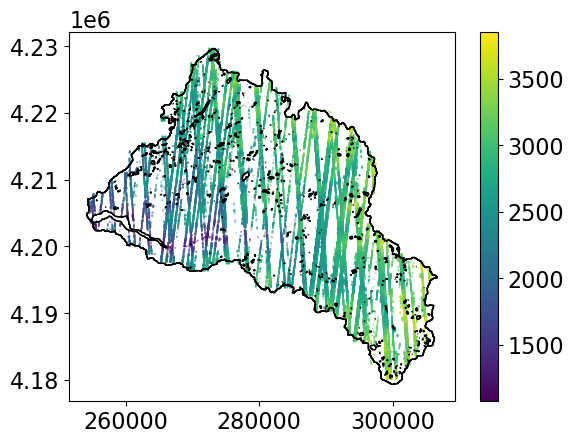

In [28]:
fig, ax = plt.subplots()

atl06sr_gdf.plot(ax=ax, column='h_mean', markersize=0.01, legend=True)
outline_nolakes.plot(ax=ax, facecolor='none')

<AxesSubplot: >

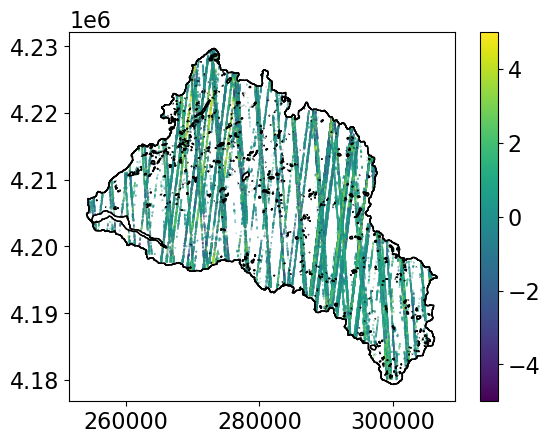

In [38]:
fig, ax = plt.subplots()

atl06sr_gdf[atl06_idx].plot(ax=ax, column='diff_plus', markersize=0.01, legend=True)
outline_nolakes.plot(ax=ax, facecolor='none')

Text(0.5, 1.0, 'ATL06SR Snow On - DEM')

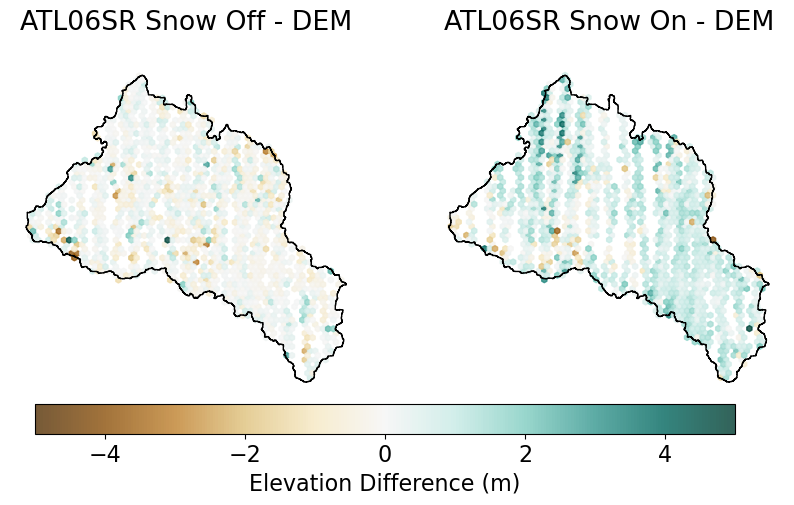

In [77]:
fig, ax = plt.subplots(1,2, figsize=(10,10))

hb_off = ax[0].hexbin(atl06sr_gdf[inner_snowoff_idx].geometry.x, 
               atl06sr_gdf[inner_snowoff_idx].geometry.y, 
               C=atl06sr_gdf[inner_snowoff_idx]['diff_plus'], 
               reduce_C_function=np.median, gridsize=60, cmap = 'BrBG', 
               mincnt=0.0001, vmin=-5, vmax=5, alpha=0.8)

hb_on = ax[1].hexbin(atl06sr_gdf[inner_snowon_idx].geometry.x, 
               atl06sr_gdf[inner_snowon_idx].geometry.y, 
               C=atl06sr_gdf[inner_snowon_idx]['diff_plus'], 
               reduce_C_function=np.median, gridsize=60, cmap = 'BrBG', 
               mincnt=0.0001, alpha=0.8, vmin=-5, vmax=5)

outline_gdf.plot(ax=ax[0], facecolor='none', edgecolor='k')
outline_gdf.plot(ax=ax[1], facecolor='none', edgecolor='k')

for axis in ax:
    axis.set_axis_off()

# https://stackoverflow.com/questions/13784201/how-to-have-one-colorbar-for-all-subplots
fig.subplots_adjust(top=0.8)
cbar_ax = fig.add_axes([0.15, 0.25, 0.7, 0.03])
plt.colorbar(hb_on, cax=cbar_ax, label='Elevation Difference (m)', orientation='horizontal')

#plt.tight_layout()
ax[0].set_title('ATL06SR Snow Off - DEM')
ax[1].set_title('ATL06SR Snow On - DEM')

In [100]:
cmap(0)

(0.32941176470588235, 0.18823529411764706, 0.0196078431372549, 1.0)

In [102]:
cmap(1000)

(0.0, 0.23529411764705882, 0.18823529411764706, 1.0)

In [116]:
!pwd

/Users/Hannah/Documents/Documents_Grad/Research/IDS_westernUS/SlideRule_tuolumne/notebooks/figure_production


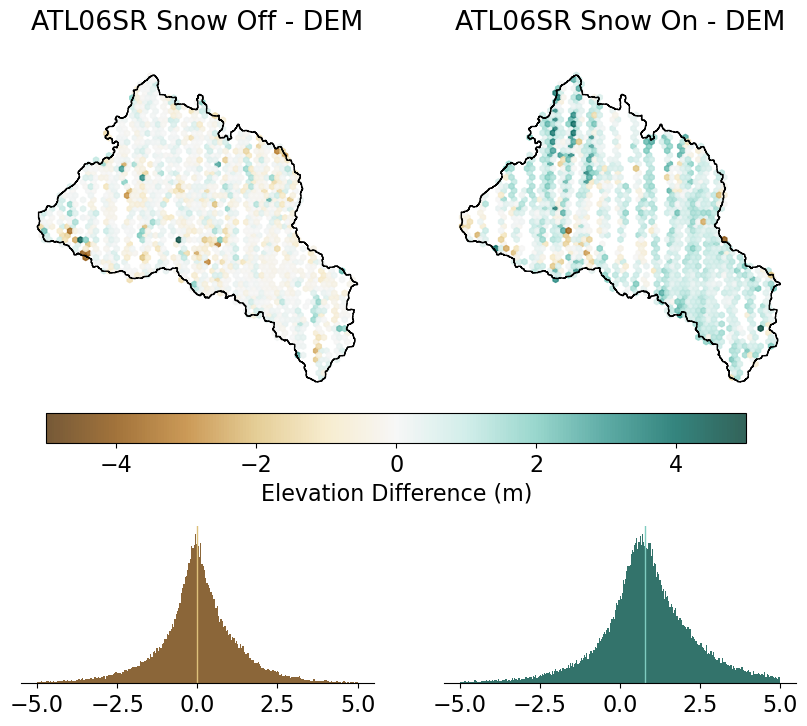

In [127]:
# add histograms to difference plots
import matplotlib
norm = matplotlib.colors.Normalize(vmin=-5, vmax=5)
cmap = matplotlib.cm.get_cmap('BrBG')

fig, ax = plt.subplots(2,2, figsize=(10,10), gridspec_kw={'height_ratios': [3, 1], 'width_ratios': [1,1]})

hb_off = ax[0,0].hexbin(atl06sr_gdf[inner_snowoff_idx].geometry.x, 
               atl06sr_gdf[inner_snowoff_idx].geometry.y, 
               C=atl06sr_gdf[inner_snowoff_idx]['diff_plus'], 
               reduce_C_function=np.median, gridsize=60, cmap = 'BrBG', 
               mincnt=0.0001, vmin=-5, vmax=5, alpha=0.8)
ax[0,0].set_axis_off()

hb_on = ax[0,1].hexbin(atl06sr_gdf[inner_snowon_idx].geometry.x, 
               atl06sr_gdf[inner_snowon_idx].geometry.y, 
               C=atl06sr_gdf[inner_snowon_idx]['diff_plus'], 
               reduce_C_function=np.median, gridsize=60, cmap = 'BrBG', 
               mincnt=0.0001, alpha=0.8, vmin=-5, vmax=5)
ax[0,1].set_axis_off()

outline_gdf.plot(ax=ax[0,0], facecolor='none', edgecolor='k')
outline_gdf.plot(ax=ax[0,1], facecolor='none', edgecolor='k')

ax[1,0].hist(atl06sr_gdf[inner_snowoff_idx]['diff_plus'], color=cmap(norm(-4.5)),\
            bins=int(np.sqrt(len(atl06sr_gdf[inner_snowoff_idx]))), alpha=0.8)
ax[1,0].axvline(x = np.nanmedian(atl06sr_gdf[inner_snowoff_idx]['diff_plus']), c=cmap(norm(-2)), linewidth=1)
#ax[1,0].set_xlabel('Snowoff Elevation Differences (m)')
# Hide the right and top spines
ax[1,0].spines.right.set_visible(False)
ax[1,0].spines.top.set_visible(False)
ax[1,0].spines.left.set_visible(False)
ax[1,0].axes.yaxis.set_visible(False)

ax[1,1].hist(atl06sr_gdf[inner_snowon_idx]['diff_plus'], color=cmap(norm(4.5)),\
            bins=int(np.sqrt(len(atl06sr_gdf[inner_snowon_idx]))), alpha=0.8)
ax[1,1].axvline(x = np.nanmedian(atl06sr_gdf[inner_snowon_idx]['diff_plus']), c=cmap(norm(2)), linewidth=1)
#ax[1,1].set_xlabel('Snow On Elevation Differences (m)')
ax[1,1].spines.right.set_visible(False)
ax[1,1].spines.top.set_visible(False)
ax[1,1].spines.left.set_visible(False)
ax[1,1].axes.yaxis.set_visible(False)

# https://stackoverflow.com/questions/13784201/how-to-have-one-colorbar-for-all-subplots
fig.subplots_adjust(top=0.8)
cbar_ax = fig.add_axes([0.15, 0.35, 0.7, 0.03])
plt.colorbar(hb_on, cax=cbar_ax, label='Elevation Difference (m)', orientation='horizontal')

#plt.tight_layout()
ax[0,0].set_title('ATL06SR Snow Off - DEM')
ax[0,1].set_title('ATL06SR Snow On - DEM')

plt.savefig('../../figures/polished/difference_map_hist.jpeg', dpi=500)

In [ ]:
# Add histogram to above map (use the teal color from colormap)

axa[2].hist(atl06sr_gdf[inner_snowoff_idx]['diff_plus'], alpha=0.5, \
            bins=int(np.sqrt(len(atl06sr_gdf[inner_snowoff_idx]))))
axa[2].set_xlim(-5,5)
axa[2].set_xlabel('Snowoff Difference (m)')
axa[2].axvline(x = np.nanmedian(atl06sr_gdf[inner_snowoff_idx]['diff_plus']), c='navy', linewidth=1)

Text(0.5, 1.0, 'ATL06SR Snow Off Difference from Snow Off ASO')

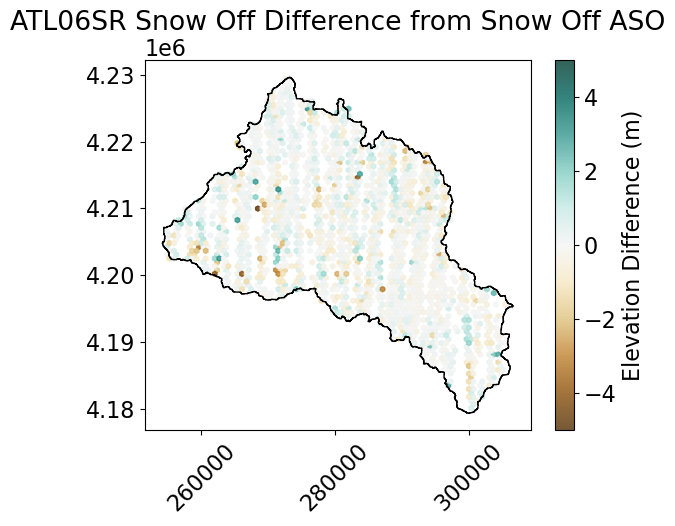

In [52]:
f, ax = plt.subplots()

hb = ax.hexbin(atl06sr_gdf[inner_snowoff_idx].geometry.x, 
               atl06sr_gdf[inner_snowoff_idx].geometry.y, 
               C=atl06sr_gdf[inner_snowoff_idx]['diff_plus'], 
               reduce_C_function=np.median, gridsize=75, alpha=0.8, cmap = 'BrBG', 
               mincnt=0.0001, vmin=-5, vmax=5)
plt.colorbar(hb, label='Elevation Difference (m)')
outline_gdf.plot(ax=ax, facecolor='none', edgecolor='k')
#plt.xlim([glas_bounds[0],glas_bounds[2]])
#plt.ylim([glas_bounds[1], glas_bounds[3]])
plt.xticks(rotation=45)
plt.title('ATL06SR Snow Off Difference from Snow Off ASO')

Text(0.5, 1.0, 'ATL06SR Snow On - DEM')

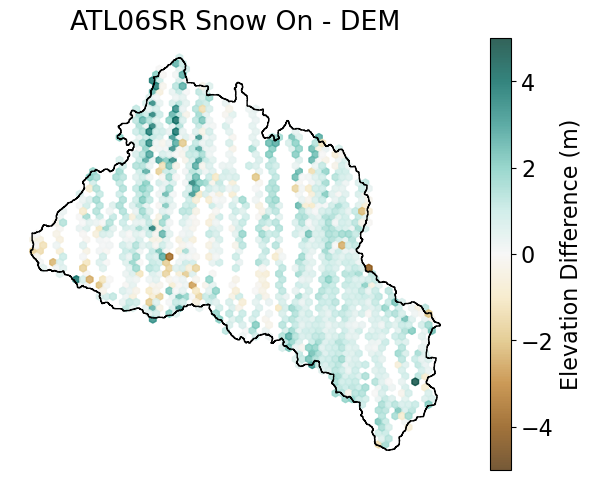

In [57]:
f, ax = plt.subplots()

hb = ax.hexbin(atl06sr_gdf[inner_snowon_idx].geometry.x, 
               atl06sr_gdf[inner_snowon_idx].geometry.y, 
               C=atl06sr_gdf[inner_snowon_idx]['diff_plus'], 
               reduce_C_function=np.median, gridsize=60, alpha=0.8, cmap = 'BrBG', 
               mincnt=0.0001, vmin=-5, vmax=5)
plt.colorbar(hb, label='Elevation Difference (m)')
outline_gdf.plot(ax=ax, facecolor='none', edgecolor='k')
ax.set_axis_off()
plt.xticks(rotation=45)
plt.tight_layout()
plt.title('ATL06SR Snow On - DEM')

In [78]:
import seaborn as sns

(array([240000., 260000., 280000., 300000., 320000.]),
 [Text(240000.0, 0, '240000'),
  Text(260000.0, 0, '260000'),
  Text(280000.0, 0, '280000'),
  Text(300000.0, 0, '300000'),
  Text(320000.0, 0, '320000')])

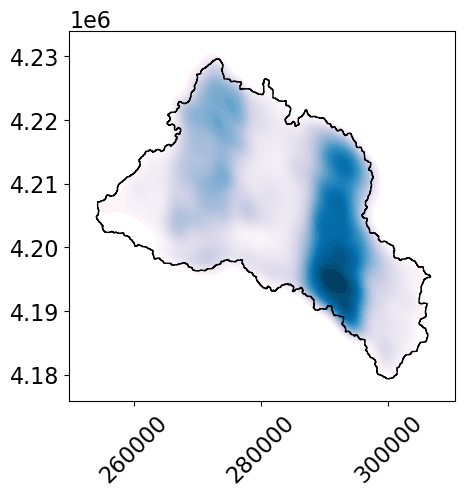

In [84]:
f, ax = plt.subplots()

kde = sns.kdeplot(data='diff_plus', x=atl06sr_gdf.geometry.x, y=atl06sr_gdf.geometry.y, fill=True, legend=True, cmap='PuBu', levels=50, ax=ax)

#plt.colorbar(kde, label='Point Density')

outline_gdf.plot(ax=ax, facecolor='none', edgecolor='k')

plt.xticks(rotation=45)
#plt.title('GLAS Kernel Density Estimator')